In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.neighbors import KNeighborsRegressor

In [2]:
SEED = 0
np.random.seed(SEED)

In [3]:
df = []
for file_path in glob.glob('kaggle/input/train*.csv'):
    df_tmp = pd.read_csv(file_path)
    df.append(df_tmp)
df = pd.concat(df)

In [4]:
df

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,0.000,0.0,49.7534,23.7184,233.2737,0.8993,0.2231,0.6365,1.1493,0.8483,1.2534,1.4449,1.9906,1.3303,1.4480,1.9148,3.4651,5.2144,6.5806,8.6385
1,0.309,0.0,55.8400,26.6200,241.6323,0.2112,2.1314,5.3552,9.7569,6.3188,9.4472,10.5769,13.6317,21.9829,16.1902,24.2780,31.1014,34.7193,31.7505,41.9167
2,0.618,0.0,55.8400,26.6200,241.3888,0.2070,10.5318,22.5612,37.2635,17.7848,33.0704,36.3160,42.5746,49.7495,31.7533,57.7289,53.6275,56.9212,47.8255,62.9436
3,0.926,0.0,55.8400,26.6200,241.1461,0.2042,29.5749,49.5111,65.6318,26.1447,58.3847,67.5130,68.0064,59.2824,36.7821,66.0832,66.8349,66.9695,50.3730,64.8363
4,1.234,0.0,55.8400,26.6200,240.9121,0.2030,49.5111,67.0368,77.8317,27.9625,71.7732,79.9474,79.8631,62.5385,39.6271,68.1441,62.0947,49.4614,52.8453,66.8445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295742,90908.346,0.0,61.6700,25.7400,0.0000,0.2000,10.9436,4.9538,17.2555,23.9772,41.3760,39.1250,41.9312,59.7614,58.7630,62.3092,60.3791,54.7785,45.7841,67.8952
295743,90908.655,0.0,61.6700,25.7400,0.0000,0.2000,8.8732,3.8830,14.5711,24.4668,41.3760,37.8295,40.9475,63.9786,56.3775,63.2123,65.8307,54.0991,46.5522,65.2822
295744,90908.965,0.0,61.6700,25.7400,0.0000,0.1997,7.2381,3.1234,11.8973,23.5061,39.4783,35.9923,32.3678,60.1664,57.5820,61.0401,59.1160,53.4361,46.7830,68.3837
295745,90909.273,0.0,61.6700,25.7400,0.0000,0.1995,5.9284,2.5713,9.9662,23.8181,41.5938,34.8888,39.6036,60.6597,57.1512,63.2123,62.0947,53.7355,45.7841,64.8363


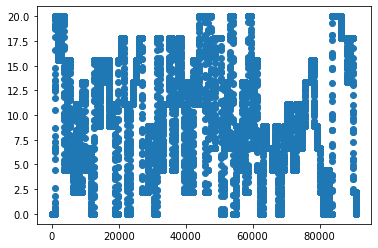

In [5]:
plt.plot(df['Time (s)'], df['CO (ppm)'], 'o')

In [6]:
x = df['Time (s)'].values
y = df['CO (ppm)'].values

In [91]:
class KNearestReg1D:
    def __init__(self, n_neighbors=12):
        self.n_neighbors = n_neighbors
    
    def fit(self, x, y):
        assert len(x.shape) == 1
        assert len(y.shape) == 1
        sorted_xy = sorted(list(zip(x, y)))
        self.sorted_x = [t[0] for t in sorted_xy]
        self.sorted_y = [t[1] for t in sorted_xy]
        
    def predict(self, x):
        if type(x) == list:
            x = np.array(x)
        assert len(x.shape) == 1
        return np.array([self.predict_point(xe) for xe in x])
        
    def predict_point(self, x):
        # 1. 가장 가까운 n_neighbors의 점 찾기
        #   1-1. Binary Search를 이용하여 가장 가까운 x' 찾기
        #   1-2. 위에서 찾은 x'로부터 좌우로 x와 가까운 점 확장
        # 2. 찾은 점 12개를 이용하여 simple linear regression하여 답 구하기
        #    (https://en.wikipedia.org/wiki/Simple_linear_regression)
        
        # 1. 가장 가까운 n_neighbors 점 찾기
        points = self.closest_points(x, n=self.n_neighbors)
        
        # 2. Linear Regression으로 추정하기
        x_near = np.array([t[0] for t in points])
        y_near = np.array([t[1] for t in points])
        sx2 = np.sum((x_near - np.mean(x_near)) ** 2)
        if sx2 == 0:
            return np.mean(y_near)
        sxy = np.sum((x_near - np.mean(x_near)) * (y_near - np.mean(y_near)))
        beta = sxy / sx2
        alpha = np.mean(y_near) - beta * np.mean(x_near)
        return alpha + beta * x
        
    def closest_points(self, x, n):
        import bisect
        # Locate the insertion point for x in a to maintain sorted order
        idx = bisect.bisect(self.sorted_x, x)
        
        # Candidate: (x_diff, x', y')
        candidates = []
        if idx < len(self.sorted_x):
            candidates.append((
                abs(self.sorted_x[idx] - x), self.sorted_x[idx], self.sorted_y[idx]
            ))
        for i in range(n + 1):
            idx_left = idx - i - 1
            if idx_left >= 0:
                candidates.append((
                    abs(self.sorted_x[idx_left] - x), self.sorted_x[idx_left], self.sorted_y[idx_left]
                ))
            idx_right = idx + i + 1
            if idx_right < len(self.sorted_x):
                candidates.append((
                    abs(self.sorted_x[idx_right] - x), self.sorted_x[idx_right], self.sorted_y[idx_right]
                ))
        closests = sorted(candidates)[:n]
        return sorted([(t[1], t[2]) for t in closests])

In [92]:
knr = KNearestReg1D()

In [93]:
knr.fit(x, y)

In [94]:
knr.predict([i * 5000 for i in range(10)])

array([ 0.  , 15.56,  4.44, 15.56, 15.56, 13.33,  8.89, 11.11,  2.22,
       20.  ])

In [83]:
knr.predict([10])

[(9.876, 0.0), (9.881, 0.0), (9.881, 0.0), (9.883, 0.0), (9.884, 0.0), (9.884, 0.0), (9.885, 0.0), (9.886, 0.0), (9.89, 0.0), (9.891, 0.0), (9.893, 0.0), (9.895, 0.0)]
0.0003382500000000159
0.0
0.0


array([0.])

In [84]:
import bisect
bisect.bisect([1,2,3], 0)

0

In [14]:
abs(-1)

1

In [95]:
df_test = pd.read_csv('kaggle/input/test_x.csv')
x_test = df_test['Time (s)'].values

In [96]:
y_pred = knr.predict(x_test)

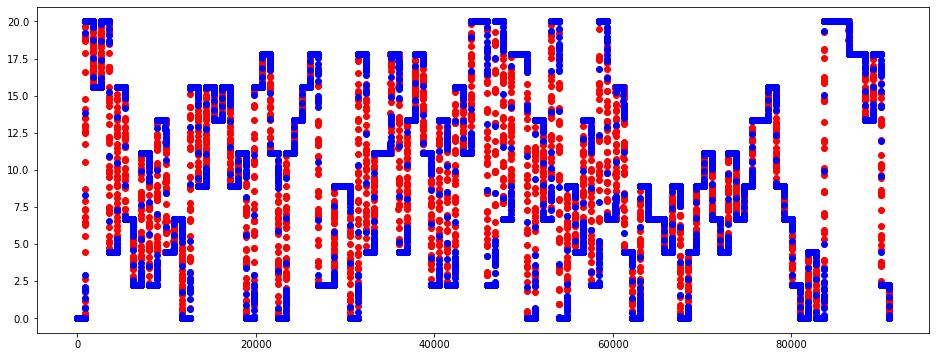

In [111]:
plt.figure(figsize=(16, 6))
plt.plot(df['Time (s)'], df['CO (ppm)'], 'ro')
plt.plot(x_test, y_pred, 'bo')
#plt.xlim(40000, 50000)
#plt.ylim(19.9999, 20.0001)


In [98]:
y_pred_df = pd.DataFrame({
    'id': [i for i in range(len(y_pred))],
    'CO (ppm)': y_pred
})

In [112]:
# Leader board 제출 결과 - Public Score: 0.00607
y_pred_df.to_csv('kaggle/output/baseline_knn.csv', index=False)

In [114]:
for i in range(1, 13):
    df = pd.read_csv('kaggle/input/train{}.csv'.format(i))
    x = df['Time (s)'].values
    y_pred = knr.predict(x)
    y = df['CO (ppm)']
    mae = np.mean(y - y_pred)
    print(i, ':', mae)
    
# 결과
# 1 : 0.0057331208752497255
# 2 : 0.005673206247275441
# 3 : 0.04665769356895598
# 4 : 0.005976852353767708
# 5 : 0.005937640091197276
# 6 : 0.005875439345567144
# 7 : 0.005832433812434164
# 8 : 0.0061324620705210655
# 9 : 0.006086746352743883
# 10 : 0.00584091113639838
# 11 : 0.015368946075726305
# 12 : 0.0056480260767462764      

1 : 0.0057331208752497255
2 : 0.005673206247275441
3 : 0.04665769356895598
4 : 0.005976852353767708
5 : 0.005937640091197276
6 : 0.005875439345567144
7 : 0.005832433812434164
8 : 0.0061324620705210655
9 : 0.006086746352743883
10 : 0.00584091113639838
11 : 0.015368946075726305
12 : 0.0056480260767462764
